8/4/25

aUTO Encoders

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras import layers

# Load data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [ ]:
# Flatten input for dense autoencoder
input_img = Input(shape=(28, 28, 1))
x = Flatten()(input_img)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
encoded = Dense(16, activation='relu')(x)

x = Dense(32, activation='relu')(encoded)
x = Dense(64, activation='relu')(x)
x = Dense(784, activation='sigmoid')(x)
decoded = Reshape((28, 28, 1))(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# Train the model
autoencoder.fit(x_train, x_train, epochs=10, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

# Predict and visualize
decoded_imgs = autoencoder.predict(x_test)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.3822 - val_loss: 0.2060
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.1920 - val_loss: 0.1665
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1640 - val_loss: 0.1540
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1540 - val_loss: 0.1478
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.1478 - val_loss: 0.1426
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1430 - val_loss: 0.1397
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1403 - val_loss: 0.1373
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1381 - val_loss: 0.1342
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1351 - val_loss: 0.1324
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1332 - val_loss: 0.1308
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


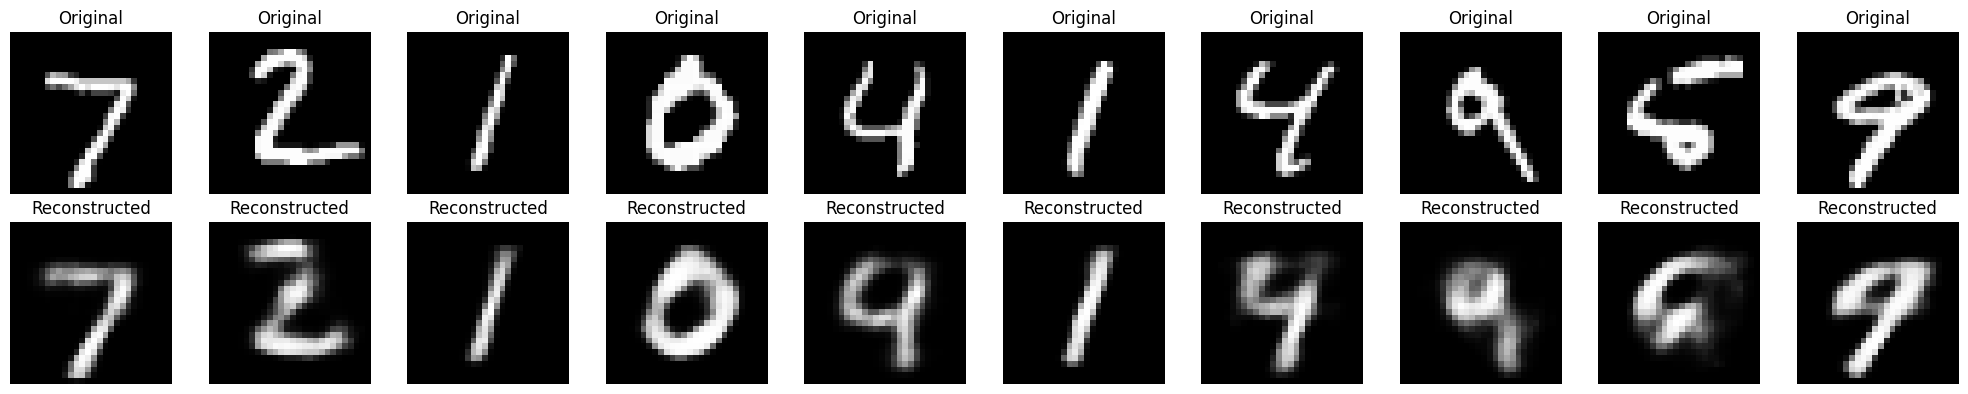

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()

Variational Autoencoders

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Load and preprocess MNIST
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = x_test.astype("float32") / 255.
x_test = np.reshape(x_test, (-1, 28, 28, 1))

In [ ]:
# Latent dimension
latent_dim = 2

# Encoder
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [ ]:
# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
# VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, outputs, name="vae")

# Loss
def vae_loss(encoder_inputs, outputs):
    # Get z_mean, z_log_var from the encoder output
    z_mean, z_log_var, _ = encoder(encoder_inputs)

    reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(
            keras.backend.flatten(encoder_inputs), keras.backend.flatten(outputs)
        )
    )
    kl_loss = -0.5 * tf.reduce_mean(
        1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    )
    return reconstruction_loss + kl_loss


vae.compile(optimizer="adam", loss=vae_loss)  # Use the custom loss function

In [ ]:
# Train
vae.fit(x_train, x_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.3151
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.2632
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - loss: 0.2633
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - loss: 0.2628
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.2629
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.2634
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.2631
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.2628
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.2628
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.2628


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

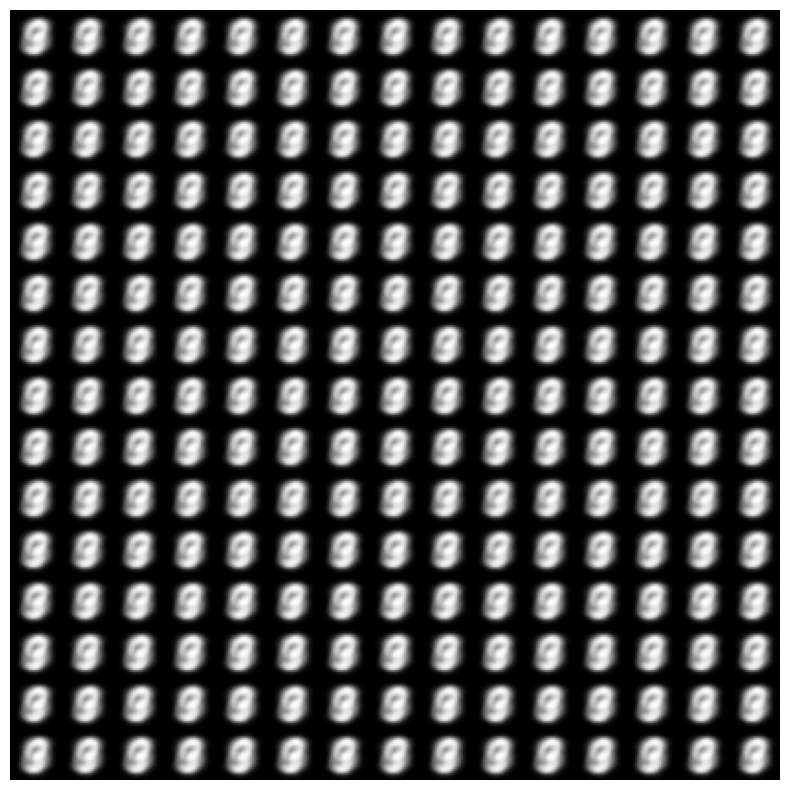

In [ ]:
# Generate 2D latent space grid
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.axis('off')
plt.show()


GAN1

text memorize categories 0-9in mnist category with textand map on data generation use this text

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Activation

In [ ]:
real_image = tf.keras.preprocessing.image.load_img('BUTTERFLY.jpeg', target_size=(432, 484))
real_image = tf.keras.preprocessing.image.img_to_array(real_image)
real_image = (real_image - 127.5) / 127.5  # Normalize to [-1, 1]
real_image = tf.expand_dims(real_image, axis=0)  # Add batch dimension

In [ ]:
def build_generator():
    inputs = Input(shape=(432, 484, 3))
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same')(inputs)
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    outputs = Activation('tanh')(x)
    return Model(inputs=inputs, outputs=outputs)

generator_img = build_generator()

In [ ]:
fake_image = generator_img.predict(real_image)
fake_image = (fake_image + 1) / 2  # Rescale from [-1, 1] to [0, 1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


In [ ]:
tf.keras.preprocessing.image.save_img('Ab_fake_image.jpg', fake_image[0])

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
digit_map = {
    'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4,
    'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9
}


In [ ]:
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
y_train = tf.keras.utils.to_categorical(y_train, 10)    # One-hot encoding


In [ ]:
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)


In [ ]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(100,)),
        layers.Dense(784, activation='tanh'),
        layers.Reshape((28, 28, 1))
    ])
    return model


In [ ]:
def build_discriminator():
    image = layers.Input(shape=(28, 28, 1))
    label = layers.Input(shape=(10,))
    x = layers.Flatten()(image)
    x = layers.Concatenate()([x, label])
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model([image, label], x)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

generator = build_generator()
discriminator = build_discriminator()

g_optimizer = tf.keras.optimizers.Adam(1e-4)
d_optimizer = tf.keras.optimizers.Adam(1e-4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([labels.shape[0], 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                    cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
def generate_image_from_text(text_label):
    idx = digit_map.get(text_label.lower(), None)
    if idx is None:
        raise ValueError("Invalid text. Use one of: " + ", ".join(digit_map.keys()))

    # Convert text label to one-hot tensor
    label = tf.convert_to_tensor(tf.keras.utils.to_categorical([idx], 10), dtype=tf.float32)

    # Generate random noise
    noise = tf.random.normal([1, 100])

    # Generate fake image
    generated_image = generator([noise, label], training=False)
    generated_image = (generated_image[0, :, :, 0] + 1) / 2.0  # Rescale from [-1,1] to [0,1]

    # Plot the image
    plt.imshow(generated_image.numpy(), cmap='gray')
    plt.title(f"Generated Image for Text: '{text_label}'")
    plt.axis('off')
    plt.show()


In [ ]:
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([labels.shape[0], 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                    cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Return gen_loss and disc_loss
    return gen_loss, disc_loss # Added this line to return the losses

In [ ]:
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([labels.shape[0], 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                    cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_gen, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [ ]:
# Training loop
EPOCHS = 50

for epoch in range(EPOCHS):
    for img_batch, label_batch in dataset:
        g_loss, d_loss = train_step(img_batch, label_batch)

        # Print generator and discriminator loss
        print(f"Epoch {epoch+1}, Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")


Epoch 1, Generator Loss: 0.8249, Discriminator Loss: 1.0124
Epoch 1, Generator Loss: 0.8236, Discriminator Loss: 0.8480
Epoch 1, Generator Loss: 0.8231, Discriminator Loss: 0.7519
Epoch 1, Generator Loss: 0.8235, Discriminator Loss: 0.6937
Epoch 1, Generator Loss: 0.8516, Discriminator Loss: 0.6304
Epoch 1, Generator Loss: 0.8589, Discriminator Loss: 0.6062
Epoch 1, Generator Loss: 0.8847, Discriminator Loss: 0.5720
Epoch 1, Generator Loss: 0.9002, Discriminator Loss: 0.5519
Epoch 1, Generator Loss: 0.9348, Discriminator Loss: 0.5241
Epoch 1, Generator Loss: 0.9536, Discriminator Loss: 0.5068
Epoch 1, Generator Loss: 0.9983, Discriminator Loss: 0.4752
Epoch 1, Generator Loss: 1.0294, Discriminator Loss: 0.4593
Epoch 1, Generator Loss: 1.0884, Discriminator Loss: 0.4262
Epoch 1, Generator Loss: 1.1002, Discriminator Loss: 0.4171
Epoch 1, Generator Loss: 1.1515, Discriminator Loss: 0.3932
Epoch 1, Generator Loss: 1.1718, Discriminator Loss: 0.3832
Epoch 1, Generator Loss: 1.2174, Discrim

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_54
Received: inputs=['Tensor(shape=(96, 100))', 'Tensor(shape=(96, 10))']
  warnings.warn(msg)


Streaming output truncated to the last 5000 lines.
Epoch 40, Generator Loss: 6.5338, Discriminator Loss: 0.1128
Epoch 40, Generator Loss: 7.6203, Discriminator Loss: 0.1602
Epoch 40, Generator Loss: 7.5634, Discriminator Loss: 0.2231
Epoch 40, Generator Loss: 6.0699, Discriminator Loss: 0.0948
Epoch 40, Generator Loss: 5.0717, Discriminator Loss: 0.1505
Epoch 40, Generator Loss: 4.5792, Discriminator Loss: 0.2188
Epoch 40, Generator Loss: 5.7025, Discriminator Loss: 0.1701
Epoch 40, Generator Loss: 6.1079, Discriminator Loss: 0.1332
Epoch 40, Generator Loss: 7.9766, Discriminator Loss: 0.1603
Epoch 40, Generator Loss: 8.8076, Discriminator Loss: 0.3474
Epoch 40, Generator Loss: 6.6968, Discriminator Loss: 0.0410
Epoch 40, Generator Loss: 4.2976, Discriminator Loss: 0.1953
Epoch 40, Generator Loss: 5.0327, Discriminator Loss: 0.0801
Epoch 40, Generator Loss: 6.0527, Discriminator Loss: 0.0743
Epoch 40, Generator Loss: 7.4203, Discriminator Loss: 0.1278
Epoch 40, Generator Loss: 8.1545, 

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_54
Received: inputs=['Tensor(shape=(1, 100))', 'Tensor(shape=(1, 10))']
  warnings.warn(msg)


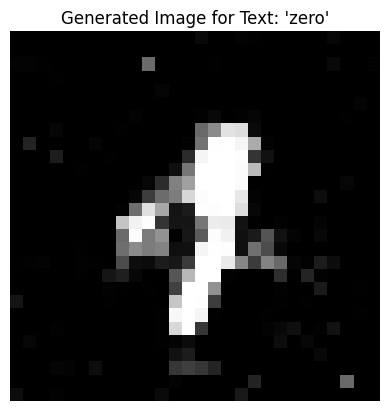

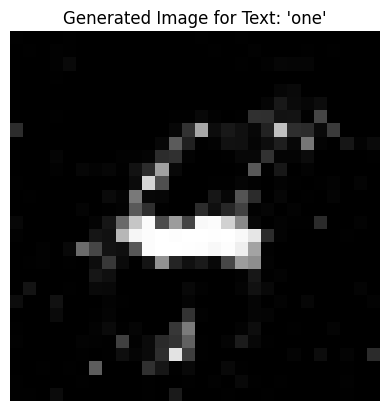

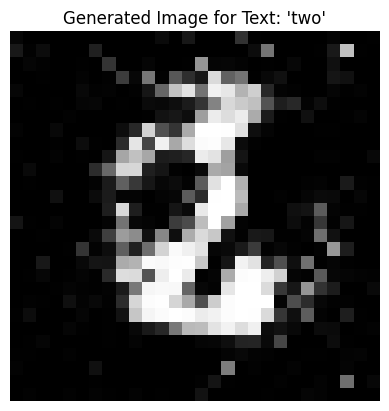

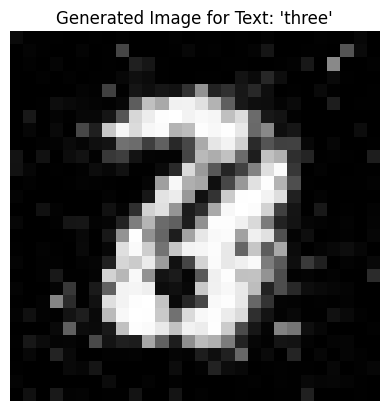

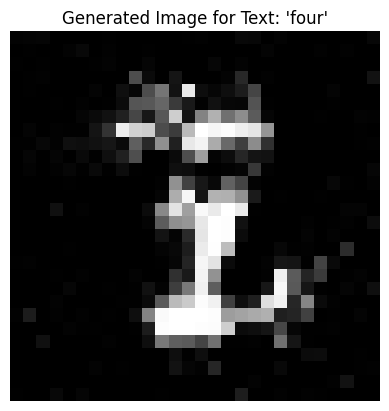

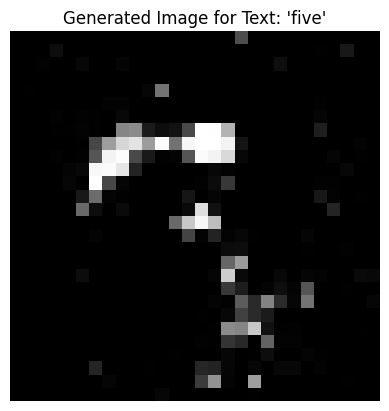

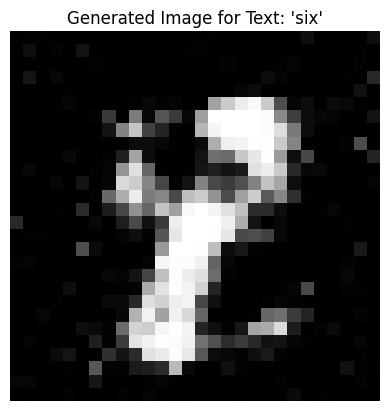

In [ ]:
# List of 7 digit labels as text
text_labels = ["zero", "one", "two", "three", "four", "five", "six"]

# Generate and show image for each label
for label in text_labels:
    generate_image_from_text(label)


GAN

In [ ]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(100,)),
        layers.Dense(784, activation='tanh'),
        layers.Reshape((28, 28, 1)),
    ])
    return model

In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ])
    return model


In [ ]:
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype('float32') - 127.5) / 127.5  # Normalize to [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension

WGAN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(100,)),
        layers.BatchNormalization(),
        layers.Dense(784, activation='tanh')
    ])
    return model

In [ ]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype('float32')
x_train = (x_train - 127.5) / 127.5  # Normalize to [-1, 1]


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Critic training
def train_critic(real_images):
    noise = tf.random.normal([batch_size, 100])
    with tf.GradientTape() as tape:
        fake_images = generator(noise, training=True)
        real_output = critic(real_images, training=True)
        fake_output = critic(fake_images, training=True)
        critic_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

    grads = tape.gradient(critic_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

    # Weight clipping
    for var in critic.trainable_variables:
        var.assign(tf.clip_by_value(var, -clip_value, clip_value))

    return critic_loss


In [ ]:
@tf.function
def train_generator():
    noise = tf.random.normal([batch_size, 100])
    with tf.GradientTape() as tape:
        fake_images = generator(noise, training=True)
        fake_output = critic(fake_images, training=True)
        gen_loss = -tf.reduce_mean(fake_output)

    grads = tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    return gen_loss


In [ ]:
import time
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Define batch_size, n_critic, and clip_value
batch_size = 64  # You can adjust the batch size as needed
n_critic = 5  # Number of times to train the critic for each generator training
clip_value = 0.01  # Weight clipping value for WGAN

# Define generator and discriminator functions
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(100,)),
        layers.BatchNormalization(),
        layers.Dense(784, activation='tanh')
    ])
    return model

def build_critic():
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(784,)),
        layers.Dense(1)
    ])
    return model

# Load MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28 * 28).astype('float32')
x_train = (x_train - 127.5) / 127.5  # Normalize to [-1, 1]

# Create a TensorFlow dataset
BUFFER_SIZE = 60000
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(batch_size)

# Build generator and critic models
generator = build_generator()
critic = build_critic()

# Create optimizers for generator and critic
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
critic_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define training loop
EPOCHS = 50

for epoch in range(EPOCHS):
    for i, real_batch in enumerate(dataset):
        # Train critic n_critic times
        for _ in range(n_critic):
            noise = tf.random.normal([batch_size, 100])
            with tf.GradientTape() as tape:
                fake_images = generator(noise, training=True)
                real_output = critic(real_batch, training=True)
                fake_output = critic(fake_images, training=True)
                critic_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

            grads = tape.gradient(critic_loss, critic.trainable_variables)
            critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

            # Weight clipping
            for var in critic.trainable_variables:
                var.assign(tf.clip_by_value(var, -clip_value, clip_value))

        # Train generator once
        noise = tf.random.normal([batch_size, 100])
        with tf.GradientTape() as tape:
            fake_images = generator(noise, training=True)
            fake_output = critic(fake_images, training=True)
            gen_loss = -tf.reduce_mean(fake_output)

        grads = tape.gradient(gen_loss, generator.trainable_variables)
        gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    print(f"Epoch {epoch}, Critic Loss: {critic_loss:.4f}, Generator Loss: {gen_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0, Critic Loss: -1.3151, Generator Loss: -2.4338
Epoch 1, Critic Loss: -0.1308, Generator Loss: -2.4587
Epoch 2, Critic Loss: -0.0141, Generator Loss: -2.2387
Epoch 3, Critic Loss: -0.0692, Generator Loss: -2.0190
Epoch 4, Critic Loss: 0.0164, Generator Loss: -1.1799
Epoch 5, Critic Loss: -0.0647, Generator Loss: -1.8548
Epoch 6, Critic Loss: -0.0588, Generator Loss: -1.4049
Epoch 7, Critic Loss: -0.0547, Generator Loss: 0.0615
Epoch 8, Critic Loss: -0.1574, Generator Loss: -1.0378
Epoch 9, Critic Loss: -0.1130, Generator Loss: -0.5773


In [ ]:
# Define training loop
EPOCHS = 50

for epoch in range(EPOCHS):
    for i, real_batch in enumerate(dataset):
        # Train critic n_critic times
        for _ in range(n_critic):
            noise = tf.random.normal([batch_size, 100])
            with tf.GradientTape() as tape:
                fake_images = generator(noise, training=True)
                real_output = critic(real_batch, training=True)
                fake_output = critic(fake_images, training=True)
                critic_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

            grads = tape.gradient(critic_loss, critic.trainable_variables)
            critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

            # Weight clipping
            for var in critic.trainable_variables:
                var.assign(tf.clip_by_value(var, -clip_value, clip_value))

        # Train generator once
        noise = tf.random.normal([batch_size, 100])
        with tf.GradientTape() as tape:
            fake_images = generator(noise, training=True)
            fake_output = critic(fake_images, training=True)
            gen_loss = -tf.reduce_mean(fake_output)

        grads = tape.gradient(gen_loss, generator.trainable_variables)
        gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    print(f"Epoch {epoch}, Critic Loss: {critic_loss:.4f}, Generator Loss: {gen_loss:.4f}")

In [ ]:
import time
EPOCHS = 50

for epoch in range(EPOCHS):
    for i, real_batch in enumerate(dataset):
        real_batch = tf.reshape(real_batch, [real_batch.shape[0], 784])

        # Train critic n_critic times
        for _ in range(n_critic):
            critic_loss = train_critic(real_batch)

        # Train generator once
        gen_loss = train_generator()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Critic Loss: {critic_loss:.4f}, Generator Loss: {gen_loss:.4f}")



NameError: name 'dataset' is not defined